In [2]:
# импорт необходимых библиотек
import pandas as pd
import re
import time
import numpy as np
import pickle
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, confusion_matrix
# TfidfVectorizer преобразует тексты в числовые вектора, отражающие важность использования каждого слова из некоторого набора
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics # набор метрик для оценки качества модели
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import GridSearchCV  # модуль поиска по сетке параметров
from sklearn.linear_model import LogisticRegression # Логистическая регрессия

import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.corpus import stopwords as nltk_stopwords

from pymystem3 import Mystem

In [3]:
nltk.download("stopwords")
stopwords = list(nltk_stopwords.words("russian"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rus_k\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# словарь видов договоров
with open("labels.json", "r", encoding="utf8") as f:
    labels = json.load(f)
labels

{'0': 'arrangement',
 '1': 'application',
 '2': 'proxy',
 '3': 'contract',
 '4': 'act',
 '5': 'order',
 '6': 'determination',
 '7': 'statute',
 '8': 'contract offer',
 '9': 'invoice',
 '10': 'bill'}

In [5]:
# загрузка данных в датафрейм
df = pd.read_csv("sample.csv")
df.head()

,class,text,lemm_text_list,lemm_text
0,arrangement,соглашение о расторжении трудового договор...,"['соглашение', 'о', 'расторжение', 'трудовой',...",соглашение о расторжение трудовой договор от к...
1,arrangement,соглашение о предоставлении опциона на заключе...,"['соглашение', 'о', 'предоставление', 'опцион'...",соглашение о предоставление опцион на заключен...
2,arrangement,соглашение о реструктуризации задолженности ...,"['соглашение', 'о', 'реструктуризация', 'задол...",соглашение о реструктуризация задолженность г ...
3,arrangement,дополнительное соглашение к договору купли пр...,"['дополнительный', 'соглашение', 'к', 'договор...",дополнительный соглашение к договор купля прод...
4,arrangement,соглашение о расторжении договора об оказании ...,"['соглашение', 'о', 'расторжение', 'договор', ...",соглашение о расторжение договор об оказание у...


In [6]:
# ограничение количества слов в списке лемматизированных слов договора
MAX_WORD = 1000 # подбирается наилучший по метрике на кроссвалидации 

In [7]:
%%time
df["lemm_text_list"] = df["lemm_text_list"].apply(lambda x: eval(x)[:MAX_WORD])
# формируем столбец 'lemm_text' - лемматизированный тест для последующей обработки в TfidfVectorizer
df["lemm_text"] = df["lemm_text_list"].apply(lambda x: " ".join(x))

CPU times: total: 203 ms
Wall time: 205 ms


In [14]:
invert_labels = {val:key for key, val in labels.items()}
invert_labels

{'arrangement': '0',
 'application': '1',
 'proxy': '2',
 'contract': '3',
 'act': '4',
 'order': '5',
 'determination': '6',
 'statute': '7',
 'contract offer': '8',
 'invoice': '9',
 'bill': '10'}

In [16]:
df['class_id'] = df['class'].map(invert_labels)

In [17]:
# лемматизированный текст договора
X = df["lemm_text"]
# целевой признак - номер класса
y = df["class_id"]

# Модель

In [18]:
# инициализация TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 3), max_features=1000)

In [19]:
# обучение TfidfVectorizer
X_grid = vectorizer.fit_transform(X)  

In [20]:
# сохранение обученного TfidfVectorizer в файл
dest = os.path.join("data", "pkl_object")
if not os.path.exists(dest):
    os.makedirs(dest)
pickle.dump(vectorizer,
            open(os.path.join(dest, "vectorizer.pkl"), "wb"),
            protocol=4)

In [40]:
%%time
# кросс-валидация на 5 фолдах и вывод метрик
metrics_for_model = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]
best_metrics = []
for scoring in metrics_for_model:
    logit = LogisticRegression(random_state=12345)
    logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={"C":[5],
                                                                    "solver": ["liblinear"],
                                                                    "max_iter":[100]},
                                        scoring=scoring, n_jobs=-1, cv=5)
    logit_grid_searcher.fit(X_grid, y)
    best_metrics.append(logit_grid_searcher.best_score_)
    
columns = ["Метрика", "Показатель метрики"] 
metrics_itog = pd.DataFrame(index=[1, 2, 3, 4], data=metrics_for_model)
metrics_itog[1] = best_metrics 
metrics_itog.columns = columns
metrics_itog

CPU times: total: 172 ms
Wall time: 403 ms


,Метрика,Показатель метрики
1,accuracy,0.948119
2,precision_macro,0.931030
3,recall_macro,0.927736
4,f1_macro,0.917918


In [22]:
# сохранение обученной модели в файл
pickle.dump(logit_grid_searcher,
            open(os.path.join(dest, "logit_grid_searcher.pkl"), "wb"),
            protocol=4)

# Тестирование модели

In [26]:
# формирование обучающей и тестовой выборки в соотношении 50% и 50% от всех доступных данных
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.5, stratify=y, random_state=12345)
# если задать разбиение 70% на 30% то метрики будут 100 процентные !!!

In [27]:
# обучение на трейне и применение на тесте TfidfVectorizer 
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=1000) # инициализация TfidfVectorizer
X_train = vectorizer.fit_transform(X_train) # обучение TfidfVectorizer на трейне
X_test = vectorizer.transform(X_test) # применение обученного TfidfVectorizer на тесте

In [28]:
# инициализация логистической регрессии (гиперпараметры по умолчанию)
lr = LogisticRegression(random_state=12345, C = 5, max_iter = 100, solver = "liblinear")
# обучение логистической регрессии на трейне
lr.fit(X_train, y_train)
# получение предсказаний на тесте
y_pred = lr.predict(X_test) 

In [29]:
# вывод метрик и confusion_matrix
accuracy_score(y_test, y_pred)

0.9880478087649402

In [41]:
precision_recall_fscore_support(y_test, y_pred, average="macro")

(0.9807899610271152, 0.9727272727272727, 0.9751287309182046, None)

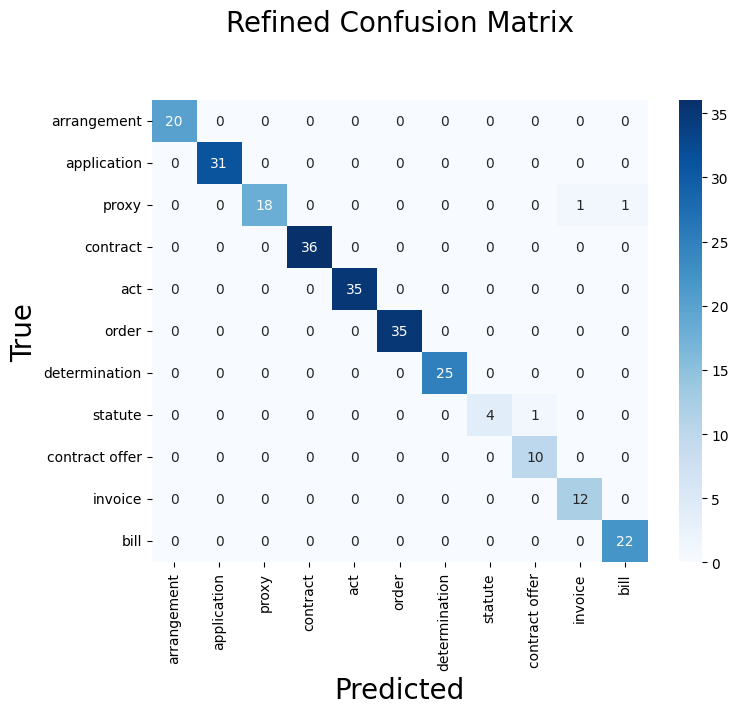

In [30]:
cm = confusion_matrix(y_test, y_pred)
class_names = labels.values()
fig = plt.figure(figsize=(8, 6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt="d", cmap="Blues")
ax.set_xlabel("Predicted", fontsize=20)
ax.xaxis.set_label_position("bottom")
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize=10)
ax.xaxis.tick_bottom()
ax.set_ylabel("True", fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize=10)
plt.yticks(rotation=0)
plt.title("Refined Confusion Matrix", fontsize=20, pad=50)
plt.show()

# Предсказание вида для нового документа

In [68]:
# случайный (новый) документ
contract = df["text"].sample(1).values[0]
contract[:200]

'договор аренды фотостудии  г  курган    апреля      года  лаптева ирина олеговна  паспортные данные  серия       номер          выдан ру ндм  зарегистрированный по адресу город светлогорск  улица свет'

In [69]:
m = Mystem()
# функция трансформации текста документа для предсказания
def ContractTransform(text):
    
    text = text.lower()
    text = re.sub("[^а-яА-ЯёЁ]", " ", text)
    lemm_text_list = [i for i in m.lemmatize(text) if len(i.strip()) > 0] 
    lemm_text_list = lemm_text_list[:MAX_WORD]
    
    return pd.Series(" ".join(lemm_text_list)) 

In [70]:
# трансформация текста случайного (нового) договора
X_test = ContractTransform(contract)
X_test

0    договор аренда фотостудия г курган апрель год ...
dtype: object

In [71]:
# применение векторайзера
X_test = vectorizer.transform(X_test)

In [72]:
# получение предсказаного номера класса
class_number = logit_grid_searcher.predict(X_test)[0]
class_number

'3'

In [73]:
# получение предсказаного названия вида документа (в текстовом виде)
labels[str(class_number)]

'contract'